In [4]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

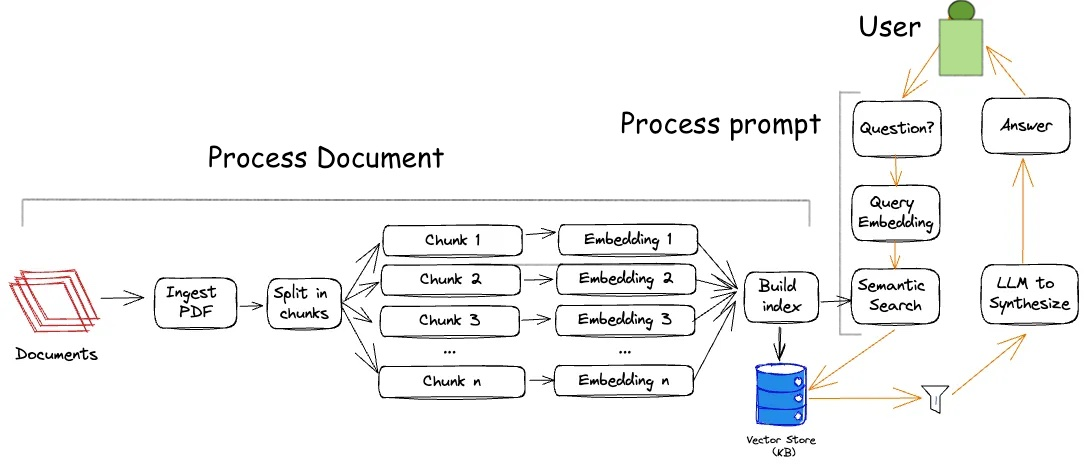

In [6]:
!pip install python-dotenv

In [19]:
from dotenv import load_dotenv

load_dotenv()

True

In [8]:
import pandas as pd

books = pd.read_csv("books_cleaned.csv")

In [9]:
books

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,9788172235222,8172235224,Mistaken Identity,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,Mistaken Identity,9788172235222 On A Train Journey Home To North...
5193,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...
5194,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...


In [10]:
books['tagged_description']

0       9780002005883 A NOVEL THAT READERS and critics...
1       9780002261982 A new 'Christie for Christmas' -...
2       9780006178736 A memorable, mesmerizing heroine...
3       9780006280897 Lewis' work on the nature of lov...
4       9780006280934 "In The Problem of Pain, C.S. Le...
                              ...                        
5192    9788172235222 On A Train Journey Home To North...
5193    9788173031014 This book tells the tale of a ma...
5194    9788179921623 Wisdom to Create a Life of Passi...
5195    9788185300535 This collection of the timeless ...
5196    9789027712059 Since the three volume edition o...
Name: tagged_description, Length: 5197, dtype: object

### Text splitting
##### 1. Handling Large Documents
- Problem : Many real-world documents (e.g., PDFs, articles, books) are too large to process as a single unit. Language models, especially transformer-based models like BERT or GPT, have limitations on the maximum input length they can handle (e.g., 512 tokens for BERT, 2048 tokens for some GPT variants).
- Solution : A text splitter breaks down large documents into smaller chunks (or passages) that fit within the model's token limit. This allows the model to process each chunk independently during both the retrieval and generation phases.

##### 2. Efficient Retrieval
- Problem : In the retrieval phase of a RAG system, the model needs to search through a large corpus of documents to find relevant information. Searching through entire documents at once would be inefficient and computationally expensive.
- Solution : By splitting documents into smaller chunks, the retrieval system can more efficiently index and search through these chunks. This improves both the speed and accuracy of the retrieval process.
- Example : Instead of searching through an entire book, the retrieval system can quickly scan through pre-split paragraphs or sections to find the most relevant information.

##### 3. Contextual Relevance
- Problem : When retrieving information, it's important to ensure that the retrieved content is contextually relevant to the query. If the text is not split properly, the model might retrieve irrelevant or overly broad information.
- Solution : A well-designed text splitter ensures that each chunk contains coherent and meaningful information. This helps the retrieval system return more relevant results.
- Example : If a user asks a question about "the causes of World War II," the text splitter ensures that the relevant historical context is contained within a single chunk, rather than being spread across multiple unrelated sections.

##### 4. Avoiding Information Loss
- Problem : If text is split arbitrarily (e.g., by fixed character or token limits), important contextual information might be lost at the boundaries between chunks.
- Solution : Advanced text splitters use techniques like overlap or semantic splitting to ensure that important information isn't lost at chunk boundaries. Overlapping chunks allow the model to retain context from neighboring sections.
- Example : If a sentence spans two chunks, the splitter might include part of the sentence in both chunks to ensure that the full meaning is preserved.

##### 5. Balancing Chunk Size
- Problem : The size of the chunks affects both the retrieval and generation phases. Too small chunks may lead to fragmented information, while too large chunks may exceed the model's token limit or make retrieval less efficient.
- Solution : The text splitter helps balance the chunk size to optimize for both retrieval and generation. Typically, chunks are kept small enough to fit within the model's token limit but large enough to contain meaningful information.
- Example : A common approach is to split text into chunks of 100-300 tokens, depending on the model's capacity and the nature of the data.


##### Common Text Splitting Techniques
- Fixed-Length Splitting :
    - Splits text into fixed-size chunks (e.g., 200 tokens per chunk).
    - Simple and fast, but may lead to fragmented information if sentences or ideas are split across chunks.
- Sentence-Based Splitting :
    - Splits text based on sentence boundaries (e.g., using punctuation marks).
    - Ensures that each chunk contains complete sentences, improving coherence.
    - May result in uneven chunk sizes, which could be problematic for models with strict token limits.
- Paragraph-Based Splitting :
    - Splits text based on paragraph boundaries.
    - Useful for documents where paragraphs represent coherent units of information.
    - May still result in chunks that are too large for some models.
- Semantic Splitting :
    - Uses natural language understanding techniques (e.g., embeddings or topic modeling) to split text based on semantic coherence.
    - More advanced and computationally expensive, but results in chunks that are more contextually relevant.
    - Example: Splitting text based on topic shifts or changes in subject matter.
- Overlapping Chunks :
    - Creates overlapping chunks to ensure that important information at chunk boundaries is not lost.
    - Example: If a chunk ends with "The causes of World War II were...", the next chunk might start with "...complex and multifaceted."

In [15]:
books["tagged_description"].to_csv("tagged_description.txt",
                                   sep="\n",
                                   index=False,
                                   header=False,
                                   encoding="utf-8")

comment:- TextLoader methods does not work directly with pandas df.

In [16]:
raw_documents = TextLoader("tagged_description.txt", encoding="utf-8").load()
text_splitter = CharacterTextSplitter(chunk_size=0, chunk_overlap=0, separator="\n")
documents = text_splitter.split_documents(raw_documents)

Created a chunk of size 1168, which is longer than the specified 0
Created a chunk of size 1214, which is longer than the specified 0
Created a chunk of size 373, which is longer than the specified 0
Created a chunk of size 309, which is longer than the specified 0
Created a chunk of size 483, which is longer than the specified 0
Created a chunk of size 482, which is longer than the specified 0
Created a chunk of size 960, which is longer than the specified 0
Created a chunk of size 188, which is longer than the specified 0
Created a chunk of size 843, which is longer than the specified 0
Created a chunk of size 296, which is longer than the specified 0
Created a chunk of size 197, which is longer than the specified 0
Created a chunk of size 881, which is longer than the specified 0
Created a chunk of size 1088, which is longer than the specified 0
Created a chunk of size 1189, which is longer than the specified 0
Created a chunk of size 304, which is longer than the specified 0
Create

The error you're encountering is a `UnicodeDecodeError`, which occurs when Python tries to read a file using an encoding that doesn't match the actual encoding of the file. In this case, the default encoding being used by the `TextLoader` is `cp1252` (commonly used on Windows), but your file (tagged_description.txt) likely contains characters that are not supported by this encoding.  
To resolve this issue, you need to specify the correct encoding when loading the file. **UTF-8** is a widely used encoding that supports a broad range of characters, so it's often a good choice. 

In [18]:
documents[0]

Document(metadata={'source': 'tagged_description.txt'}, page_content='9780002005883 A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gi

In [20]:
db_books = Chroma.from_documents(
    documents,
    embedding=OpenAIEmbeddings())

In [21]:
query = "A book to teach children about nature"
docs = db_books.similarity_search(query, k = 10)
docs

[Document(id='9671f582-ba7b-4aa6-8849-874d7c4de23e', metadata={'source': 'tagged_description.txt'}, page_content='9780786808069 Children will discover the exciting world of their own backyard in this introduction to familiar animals from cats and dogs to bugs and frogs. The combination of photographs, illustrations, and fun facts make this an accessible and delightful learning experience.'),
 Document(id='8de59f59-aa71-461b-9ad3-93c534739079', metadata={'source': 'tagged_description.txt'}, page_content="9780786808380 Introduce your babies to birds, cats, dogs, and babies through fine art, illustration, and photographs. These books are a rare opportunity to expose little ones to a range of images on a single subject, from simple child's drawings and abstract art to playful photos. A brief text accompanies each image, introducing the baby to some basic -- and sometimes playful -- information about the subjects."),
 Document(id='f5d0ebfa-ac38-4dff-856d-5e8479d75a03', metadata={'source': '

In [22]:
books[books["isbn13"] == int(docs[0].page_content.split()[0].strip())]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
3747,9780786808069,0786808063,Baby Einstein: Neighborhood Animals,Marilyn Singer;Julie Aigner-Clark,Juvenile Fiction,http://books.google.com/books/content?id=X9a4P...,Children will discover the exciting world of t...,2001.0,3.89,16.0,180.0,Baby Einstein: Neighborhood Animals,9780786808069 Children will discover the excit...


In [25]:
def retrieve_semantic_recommendations(
        query: str,
        top_k: int = 10,
) -> pd.DataFrame:
    recs = db_books.similarity_search(query, k = 50)

    books_list = []

    for i in range(0, len(recs)):
        books_list += [int(recs[i].page_content.strip('"').split()[0])]

    return books[books["isbn13"].isin(books_list)]

In [26]:
retrieve_semantic_recommendations("A book to teach children about nature")

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
31,9780007105045,0007105045,Tree and Leaf,John Ronald Reuel Tolkien,Literary Collections,http://books.google.com/books/content?id=aPb_A...,"""The two works 'On fairy-stories' and 'Leaf by...",2001.0,4.09,176.0,2245.0,Tree and Leaf: The Homecoming of Beorhtnoth : ...,"9780007105045 ""The two works 'On fairy-stories..."
59,9780007151240,0007151241,The Family Way,Tony Parsons,Parenthood,http://books.google.com/books/content?id=dJEIx...,It should be the most natural thing in the wor...,2005.0,3.51,400.0,2095.0,The Family Way,9780007151240 It should be the most natural th...
143,9780060546571,0060546573,Three Rotten Eggs,Gregory Maguire,Juvenile Fiction,http://books.google.com/books/content?id=t2pWl...,The students of Miss Earth's class in rural Ve...,2005.0,3.74,240.0,76.0,Three Rotten Eggs,9780060546571 The students of Miss Earth's cla...
429,9780064434980,0064434982,The Deer in the Wood,Laura Ingalls Wilder,Juvenile Fiction,http://books.google.com/books/content?id=V7YDW...,Even the youngest child can enjoy a special ad...,1999.0,4.17,32.0,302.0,The Deer in the Wood,9780064434980 Even the youngest child can enjo...
442,9780067575208,006757520X,The Sense of Wonder,Rachel Carson,Nature,http://books.google.com/books/content?id=Zee5S...,"First published more than three decades ago, t...",1998.0,4.39,112.0,1160.0,The Sense of Wonder,9780067575208 First published more than three ...
692,9780140448009,0140448004,Three Tales,Gustave Flaubert;Roger Whitehouse;Geoffrey Wall,Fiction,http://books.google.com/books/content?id=XFzga...,Features short fiction by the French naturalis...,2005.0,3.71,110.0,3050.0,Three Tales,9780140448009 Features short fiction by the Fr...
707,9780140568196,0140568190,The Giraffe and the Pelly and Me,Roald Dahl;Quentin Blake,Candy,http://books.google.com/books/content?id=J7FdI...,"A Dahl story in which the giraffe, the pelican...",2001.0,3.81,32.0,16265.0,The Giraffe and the Pelly and Me,9780140568196 A Dahl story in which the giraff...
711,9780140621624,0140621628,The Railway Children,E. Nesbit,Fiction,http://books.google.com/books/content?id=fFesd...,"When their father is sent away to prison, thre...",1995.0,4.00,212.0,178.0,The Railway Children,9780140621624 When their father is sent away t...
763,9780141186078,0141186070,The Log from the Sea of Cortez,John Steinbeck,Biography & Autobiography,http://books.google.com/books/content?id=9CrIf...,This light-hearted journal tells of John Stein...,2001.0,3.84,288.0,3226.0,The Log from the Sea of Cortez,9780141186078 This light-hearted journal tells...
812,9780142302279,0142302279,Dirty Beasts,Roald Dahl,Juvenile Nonfiction,NaN,Poems tell the stories of a smart pig who outw...,2002.0,4.02,32.0,3953.0,Dirty Beasts,9780142302279 Poems tell the stories of a smar...
